In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from collections import Counter
import os

In [8]:
train_set = pd.read_csv('../data/written_name_train_v2.csv')
val_set = pd.read_csv('../data/written_name_validation_v2.csv')
test_set = pd.read_csv('../data/written_name_test_v2.csv')

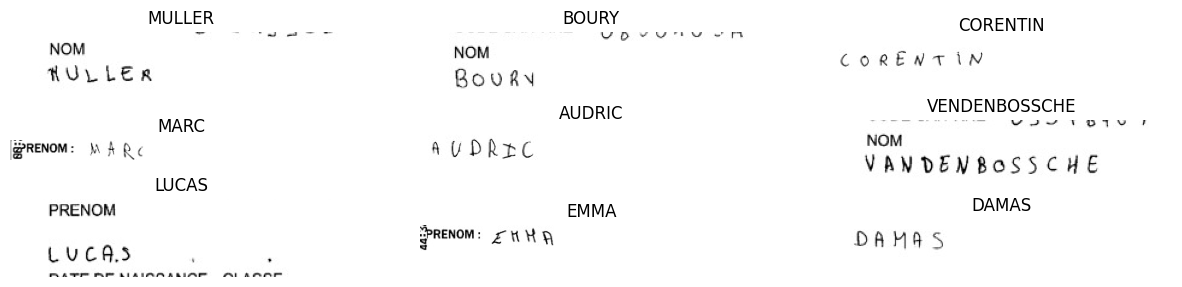

In [15]:
plt.figure(figsize=(15, 8))

for idx in range(9):  
    ax = plt.subplot(3, 3, idx + 1)  
    random_index = random.randint(0, len(train_set) - 1)  
    img_path = '../data/train_v2/train/' + train_set.loc[random_index, 'FILENAME']
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    plt.imshow(img, cmap='gray')  
    plt.title(train_set.loc[random_index, 'IDENTITY'], fontsize=12)  
    plt.axis('off')  

plt.subplots_adjust(wspace=0.2, hspace=-0.8)  

In [16]:
print("Count of NaN values in training set     : ", train_set['IDENTITY'].isnull().sum())
print("Count of NaN values in validation set   : ", val_set['IDENTITY'].isnull().sum())
print("Count of NaN values in test set         : ", test_set['IDENTITY'].isnull().sum())

Count of NaN values in training set     :  565
Count of NaN values in validation set   :  78
Count of NaN values in test set         :  70


In [17]:
train_set.dropna(axis=0, inplace=True)
val_set.dropna(axis=0, inplace=True)
test_set.dropna(axis=0, inplace = True)

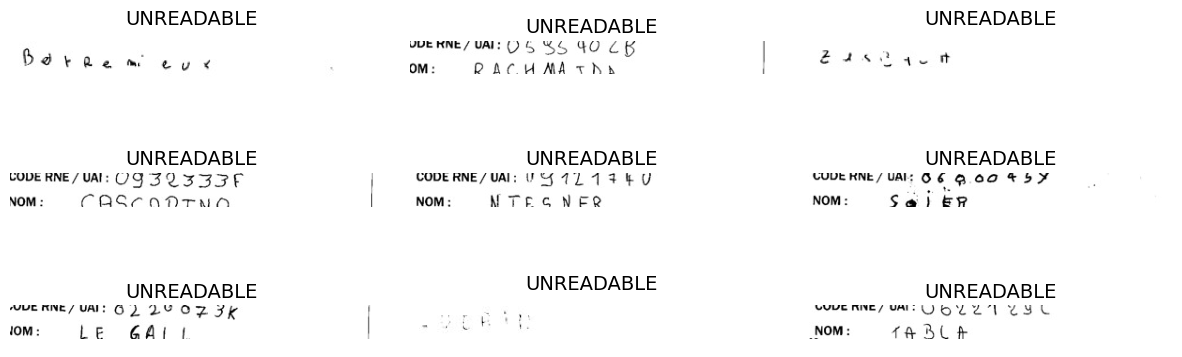

In [18]:
# Extract unreadable samples from the training set
unreadable_samples = train_set[train_set['IDENTITY'] == 'UNREADABLE']
unreadable_samples.reset_index(inplace=True, drop=True)

# Set up the figure for displaying images
plt.figure(figsize=(15, 5))  # Increased size for better visibility

# Loop through the first 6 unreadable samples to display them
for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)  # Create a subplot for each image
    img_path = '../data/train_v2/train/' + unreadable_samples.loc[idx, 'FILENAME']
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    plt.imshow(img, cmap='gray')  # Display the image
    plt.title(unreadable_samples.loc[idx, 'IDENTITY'], fontsize=14)  # Set title with larger font size
    plt.axis('off')  # Hide the axis

plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing between subplots for better layout

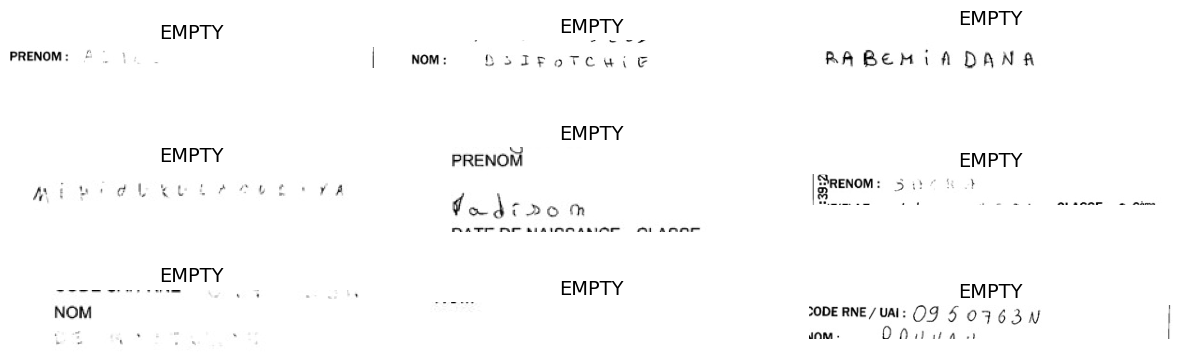

In [19]:
# Extract unreadable samples from the training set
empty_samples = train_set[train_set['IDENTITY'] == 'EMPTY']
empty_samples.reset_index(inplace=True, drop=True)

# Set up the figure for displaying images
plt.figure(figsize=(15,5))  # Increased size for better visibility

# Loop through the first 6 unreadable samples to display them
for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)  # Create a subplot for each image
    img_path = '../data/train_v2/train/' + empty_samples.loc[idx, 'FILENAME']
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    plt.imshow(img, cmap='gray')  # Display the image
    plt.title(empty_samples.loc[idx, 'IDENTITY'], fontsize=14)  # Set title with larger font size
    plt.axis('off')  # Hide the axis

plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing between subplots for better layout

In [20]:
train_set = train_set[train_set['IDENTITY'] != 'UNREADABLE']
val_set = val_set[val_set['IDENTITY'] != 'UNREADABLE']
test_set = test_set[test_set['IDENTITY'] != 'UNREADABLE']

In [21]:
train_set = train_set[train_set['IDENTITY'] != 'EMPTY']
val_set = val_set[val_set['IDENTITY'] != 'EMPTY']
test_set = test_set[test_set['IDENTITY'] != 'EMPTY']

In [22]:
train_set['IDENTITY'] = train_set['IDENTITY'].str.upper()
val_set['IDENTITY'] = val_set['IDENTITY'].str.upper()
test_set['IDENTITY'] = test_set['IDENTITY'].str.upper()


In [23]:
train_set.reset_index(inplace = True, drop=True) 
val_set.reset_index(inplace = True, drop=True)
test_set.reset_index(inplace = True, drop=True)

In [24]:
def preprocess(img):
    (h, w) = img.shape
    
    # Create a blank white image
    final_img = np.ones([64, 256]) * 255  
    
    # Crop the image if it exceeds the specified dimensions
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    # Place the cropped image onto the blank image
    final_img[:h, :w] = img
    
    # Rotate the image clockwise
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [25]:
train_size = 30000
val_size= 3000
test_size = test_set.shape[0]

In [26]:
# Preprocess the training images
train_x = [preprocess(cv2.imread('../data/train_v2/train/' + train_set.loc[i, 'FILENAME'], cv2.IMREAD_GRAYSCALE)) / 255.0 for i in range(train_size)]


KeyboardInterrupt: 

In [ ]:
# Preprocess the validation images
val_x = [preprocess(cv2.imread('../data/validation_v2/validation/' + val_set.loc[i, 'FILENAME'], cv2.IMREAD_GRAYSCALE)) / 255.0 for i in range(val_size)]


In [ ]:
# Preprocess the validation images
test_x = [preprocess(cv2.imread('../data/test_v2/validation/' + test_set.loc[i, 'FILENAME'], cv2.IMREAD_GRAYSCALE)) / 255.0 for i in range(val_size)]


In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
val_x = np.array(val_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

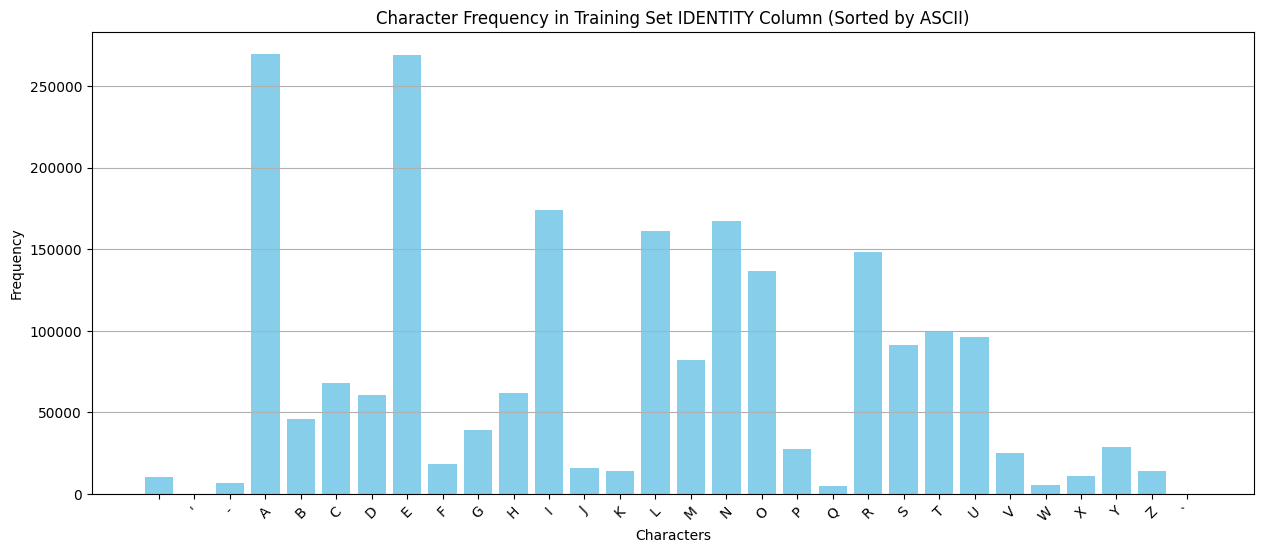

In [27]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the frequency of each character in the IDENTITY column of the training set
train_identities = train_set['IDENTITY']
all_text = ''.join(train_identities)  # Combine all names into a single string

# Use Counter to count character frequencies
char_frequency = Counter(all_text)

# Sort characters by ASCII values
sorted_char_frequency = dict(sorted(char_frequency.items()))

# Prepare data for plotting
characters = list(sorted_char_frequency.keys())
frequencies = list(sorted_char_frequency.values())

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(characters, frequencies, color='skyblue')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Frequency in Training Set IDENTITY Column (Sorted by ASCII)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

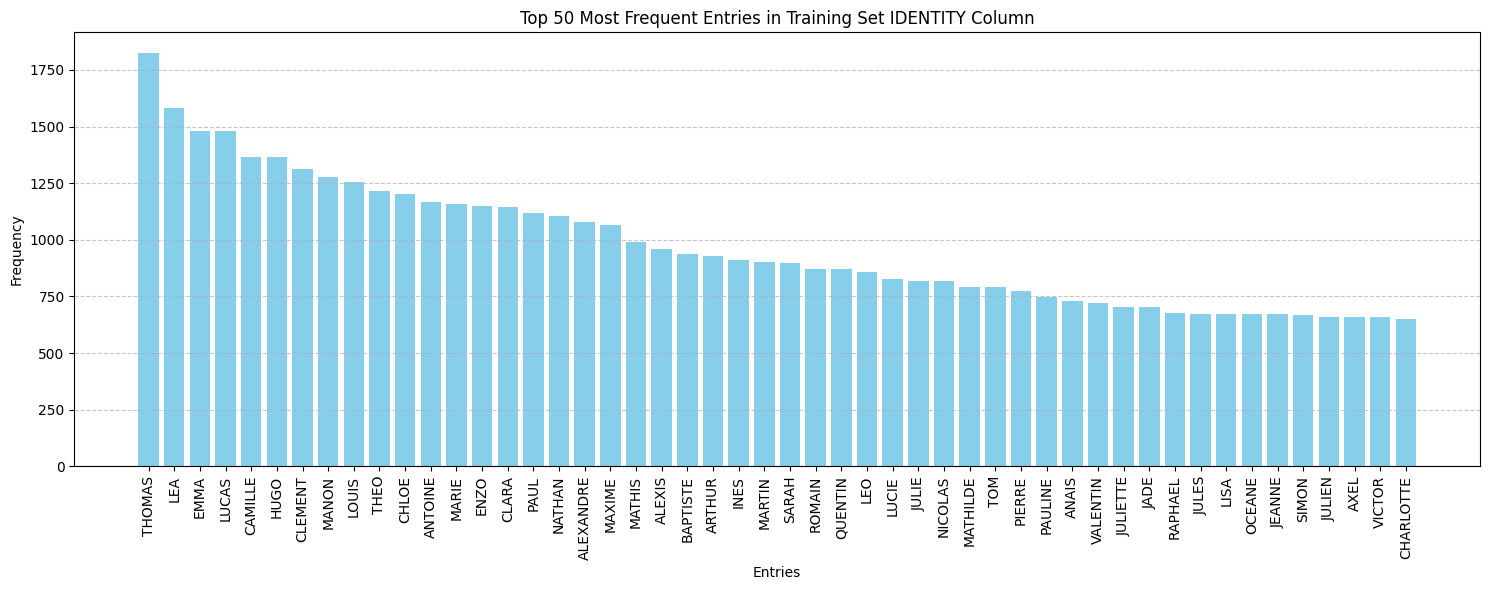

In [28]:
# Count the frequency of each entry in the IDENTITY column
identity_frequency = Counter(train_set['IDENTITY'])

# Get the top 50 most common entries
top_50_entries = identity_frequency.most_common(50)

# Separate the entries and their frequencies for plotting
entries = [entry for entry, _ in top_50_entries]
frequencies = [freq for _, freq in top_50_entries]

# Plotting the histogram
plt.figure(figsize=(15, 6))
plt.bar(entries, frequencies, color='skyblue')
plt.xlabel('Entries')
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent Entries in Training Set IDENTITY Column')
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [26]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34
num_of_characters = len(alphabets) + 1 
num_of_timestamps = 64 


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_set.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_set.loc[i, 'IDENTITY'])]= label_to_num(train_set.loc[i, 'IDENTITY'])    

In [ ]:
val_y = np.ones([val_size, max_str_len]) * -1
val_label_len = np.zeros([val_size, 1])
val_input_len = np.ones([val_size, 1]) * (num_of_timestamps-2)
val_output = np.zeros([val_size])

for i in range(val_size):
    val_label_len[i] = len(val_set.loc[i, 'IDENTITY'])
    val_y[i, 0:len(val_set.loc[i, 'IDENTITY'])]= label_to_num(val_set.loc[i, 'IDENTITY'])    

In [ ]:
test_y = np.ones([test_size, max_str_len]) * -1  
test_label_len = np.zeros([test_size, 1])  
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps - 2)  
test_output = np.zeros([test_size])  


for i in range(test_size):
    test_label_len[i] = len(test_set.loc[i, 'IDENTITY'])  
    test_y[i, 0:len(test_set.loc[i, 'IDENTITY'])] = label_to_num(test_set.loc[i, 'IDENTITY'])  


print('True label : ', test_set.loc[10, 'IDENTITY'], '\ntest_y : ', test_y[10], '\ntest_label_len : ', test_label_len[10], '\ntest_input_len : ', test_input_len[100])

In [27]:
# Input layer
input_data = keras.layers.Input(shape=(256, 64, 1))

# Convolutional layers with Batch Normalization and Activation
inner = keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)  
inner = keras.layers.BatchNormalization()(inner)
inner = keras.layers.Activation('relu')(inner)
inner = keras.layers.MaxPooling2D(pool_size=(2, 2))(inner)

inner = keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = keras.layers.BatchNormalization()(inner)
inner = keras.layers.Activation('relu')(inner)
inner = keras.layers.MaxPooling2D(pool_size=(2, 2))(inner)
inner = keras.layers.Dropout(0.3)(inner)

inner = keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = keras.layers.BatchNormalization()(inner)
inner = keras.layers.Activation('relu')(inner)
inner = keras.layers.MaxPooling2D(pool_size=(1, 2))(inner)
inner = keras.layers.Dropout(0.3)(inner)

# CNN to RNN transition
inner = keras.layers.Reshape(target_shape=((64, 1024)))(inner)
inner = keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(inner)

# RNN layers
inner = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(inner)
inner = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(inner)

# Output layer
inner = keras.layers.Dense(num_of_characters, kernel_initializer='he_normal')(inner)
y_pred = keras.layers.Activation('softmax')(inner)

# Model definition
model = keras.models.Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

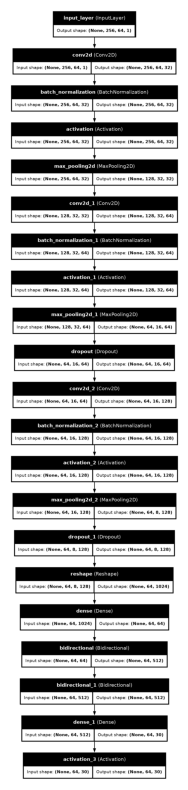

In [28]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image

# Save the model diagram
plot_model(
    model,
    to_file="cnn_rnn_model.png",
    show_shapes=True,         # Include shapes of layers
    show_layer_names=True,    # Include layer names
    expand_nested=True,       # Expand nested structures
    dpi=100                   # Resolution of the diagram
)

# Display the model diagram
image = Image.open("cnn_rnn_model.png")
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(shape=[max_str_len], dtype='float32')
input_length = Input(shape=[1], dtype='int64')
label_length = Input(shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([val_x, val_y, val_input_len, val_label_len], val_output),
                epochs=60, batch_size=128)

In [ ]:
# Saving the model
model_final.save('ctc_model.h5')

print("Model saved as 'ctc_model.h5'")

# Save the model in .keras format
model_final.save('ctc_model.keras')

print("Model saved as 'ctc_model.keras'")

In [33]:
from keras.models import load_model
model_keras = load_model('ctc_model.h5')
print("Model loaded from 'ctc_model.h5'")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'ctc_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
preds = model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = test_set.loc[0:test_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    try:
        pr = prediction[i]
        tr = y_true[i]
        # print(pr)
        # print(tr)
        total_char += len(tr)
        
        for j in range(min(len(tr), len(pr))):
            if tr[j] == pr[j]:
                correct_char += 1
                
        if pr == tr :
            correct += 1 
    except Exception as poo:
        # print(poo)
        continue
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/test_size))

In [ ]:
# Assuming 'y_true' contains the true labels and 'prediction' contains the predicted labels
y_true = test_set.loc[0:test_size, 'IDENTITY'].values  # Get true labels as a numpy array

# Create a DataFrame to hold the true and predicted values
results_df = pd.DataFrame({
    'True Labels': y_true,
    'Predictions': prediction
})

# Save the DataFrame to a CSV file
results_df.to_csv('predictions_crnn.csv', index=False)

print("Saved true labels and predictions to 'predictions_crnn.csv'")

In [ ]:
from collections import defaultdict

char_counts = defaultdict(lambda: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0})


for i in range(len(prediction)):
    try:
        pr = prediction[i]
        tr = y_true[i]

        
        true_chars = set(tr)
        pred_chars = set(pr)

        
        for char in true_chars.union(pred_chars):
            if char in true_chars and char in pred_chars:
                
                char_counts[char]['TP'] += min(tr.count(char), pr.count(char))
            if char not in true_chars and char in pred_chars:
                
                char_counts[char]['FP'] += pr.count(char)
            if char in true_chars and char not in pred_chars:
                
                char_counts[char]['FN'] += tr.count(char)

    except Exception as e:
        print(f"Error at index {i}: {e}")
        continue


f1_scores = {}
for char, counts in char_counts.items():
    TP, FP, FN = counts['TP'], counts['FP'], counts['FN']
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    f1_scores[char] = f1


print(f"{'Character':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}")
for char in sorted(f1_scores.keys()):
    TP, FP, FN = char_counts[char]['TP'], char_counts[char]['FP'], char_counts[char]['FN']
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = f1_scores[char]
    print(f"{char:<10}{precision:<10.2f}{recall:<10.2f}{f1:<10.2f}")


overall_f1 = sum(f1_scores.values()) / len(f1_scores)
print(f"\nOverall F1-Score: {overall_f1:.2f}")
